In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Define paths
DATA_PATH = '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset'

# Check available languages
available_languages = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
print("Available languages:", available_languages)

Available languages: ['Punjabi', 'Tamil', 'Hindi', 'Bengali', 'Telugu', 'Kannada', 'Gujarati', 'Urdu', 'Marathi', 'Malayalam']


# Task A: MFCC Feature Extraction

In [4]:
class MFCCExtractor:    
    def __init__(self, n_mfcc=13, sr=22050, hop_length=512, n_fft=2048):
        self.n_mfcc = n_mfcc
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
    
    def extract_mfcc(self, file_path):
        try:
            # Load audio file
            y, sr = librosa.load(file_path, sr=self.sr)
            
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                hop_length=self.hop_length,
                n_fft=self.n_fft
            )
            
            return mfcc
        except Exception as e:
            print(f"Error extracting MFCC from {file_path}: {e}")
            return None
    
    def visualize_mfcc(self, mfcc, title="MFCC Spectrogram"):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            mfcc, 
            x_axis='time',
            sr=self.sr,
            hop_length=self.hop_length
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    def compute_statistics(self, mfcc):
        mean = np.mean(mfcc, axis=1)
        variance = np.var(mfcc, axis=1)
        return mean, variance

In [5]:
class DataLoader:  
    def __init__(self, data_path):
        self.data_path = data_path
        self.languages = self._get_languages()
        
    def _get_languages(self):
        return [d for d in os.listdir(self.data_path) 
                if os.path.isdir(os.path.join(self.data_path, d))]
    
    def get_file_paths(self, selected_languages=None, max_files_per_language=None):
        if selected_languages is None:
            selected_languages = self.languages
        else:
            # Ensure all selected languages are available
            selected_languages = [lang for lang in selected_languages if lang in self.languages]
        
        file_paths = []
        
        for language in selected_languages:
            language_path = os.path.join(self.data_path, language)
            files = [f for f in os.listdir(language_path) 
                    if f.endswith('.wav') or f.endswith('.mp3')]
            
            if max_files_per_language is not None:
                files = files[:max_files_per_language]
            
            for file in files:
                file_path = os.path.join(language_path, file)
                file_paths.append((file_path, language))
        
        return file_paths

In [6]:
def visualize_language_statistics(language_stats):
    # Compute average statistics for each language
    avg_means = {}
    avg_variances = {}
    
    for language, stats in language_stats.items():
        if stats['means']:
            avg_means[language] = np.mean(stats['means'], axis=0)
            avg_variances[language] = np.mean(stats['variances'], axis=0)
    
    # Visualize average means
    plt.figure(figsize=(12, 6))
    for language, means in avg_means.items():
        plt.plot(means, label=language)
    plt.title('Average MFCC Means by Language')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualize average variances
    plt.figure(figsize=(12, 6))
    for language, variances in avg_variances.items():
        plt.plot(variances, label=language)
    plt.title('Average MFCC Variances by Language')
    plt.xlabel('MFCC Coefficient')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Create a combined visualization for comparison
    plt.figure(figsize=(15, 10))
    
    for i, language in enumerate(avg_means.keys()):
        plt.subplot(len(avg_means), 1, i+1)
        plt.plot(avg_means[language], 'b-', label=f'Mean')
        plt.plot(avg_variances[language], 'r-', label=f'Variance')
        plt.title(f'{language} - MFCC Statistics')
        plt.xlabel('MFCC Coefficient')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [7]:
def run_task_a(data_path, selected_languages, num_samples=5):
    print("====================================")
    print("Task A: MFCC Feature Extraction")
    print("====================================")
    
    # Initialize data loader and MFCC extractor
    data_loader = DataLoader(data_path)
    mfcc_extractor = MFCCExtractor()
    
    # Get a subset of files for visualization
    file_paths = data_loader.get_file_paths(
        selected_languages=selected_languages,
        max_files_per_language=num_samples
    )
    
    # Statistics storage for each language
    language_stats = {lang: {'means': [], 'variances': []} for lang in selected_languages}
    
    # Extract and visualize MFCC features
    for file_path, language in file_paths:
        print(f"Processing: {os.path.basename(file_path)} ({language})")
        mfcc = mfcc_extractor.extract_mfcc(file_path)
        
        if mfcc is not None:
            # Visualize MFCC
            mfcc_extractor.visualize_mfcc(
                mfcc,
                title=f"MFCC Spectrogram - {language} - {os.path.basename(file_path)}"
            )
            
            # Compute and store statistics
            mean, variance = mfcc_extractor.compute_statistics(mfcc)
            language_stats[language]['means'].append(mean)
            language_stats[language]['variances'].append(variance)
    
    # Compute and visualize average statistics for each language
    visualize_language_statistics(language_stats)
    
    return language_stats

Task A: MFCC Feature Extraction
Processing: 23694.mp3 (Hindi)


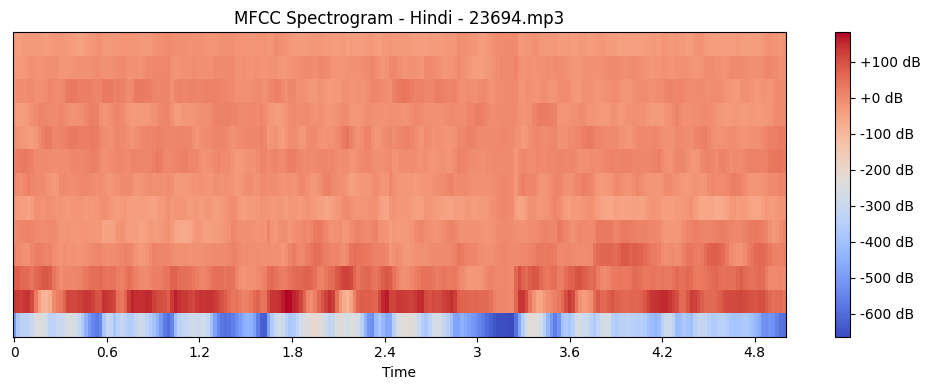

Processing: 13738.mp3 (Hindi)


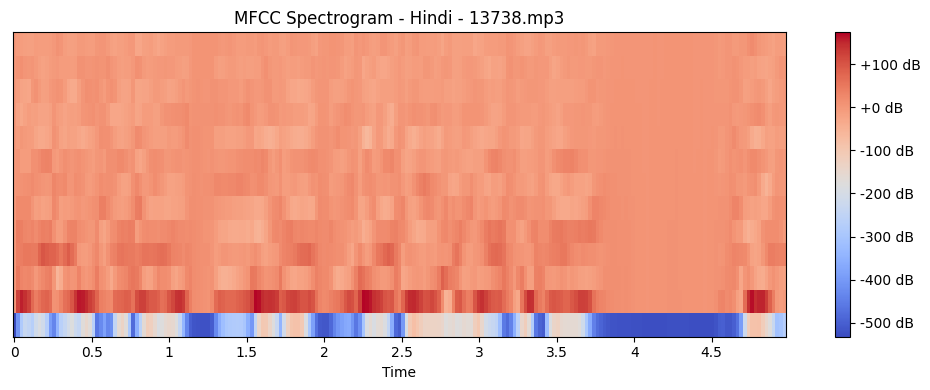

Processing: 13802.mp3 (Hindi)


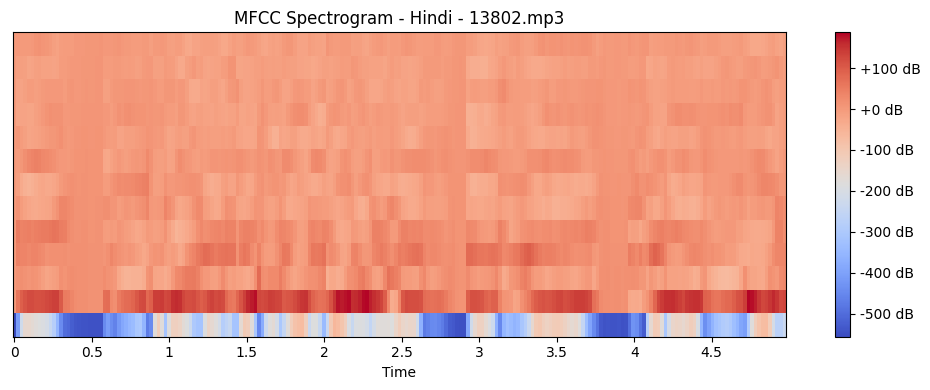

Processing: 23694.mp3 (Bengali)


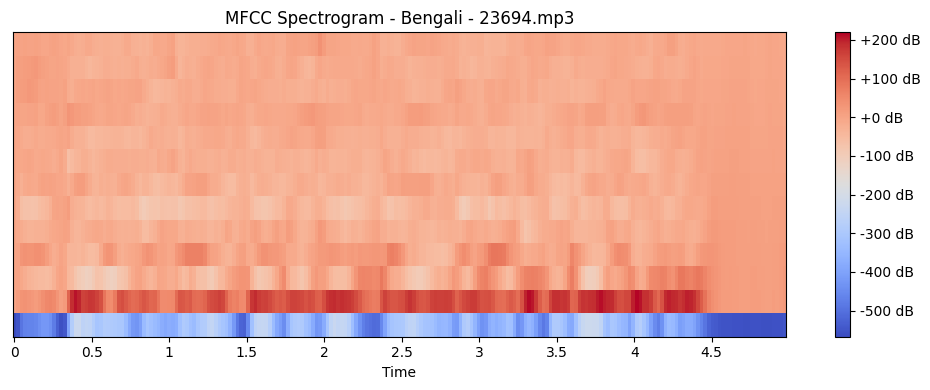

Processing: 13738.mp3 (Bengali)


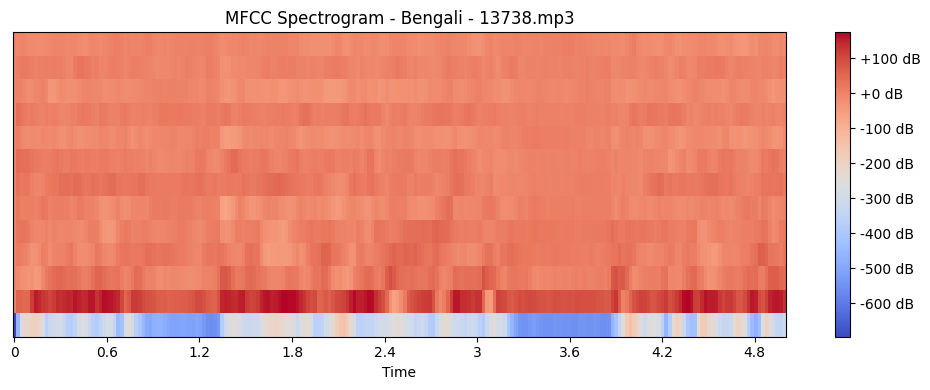

Processing: 13802.mp3 (Bengali)


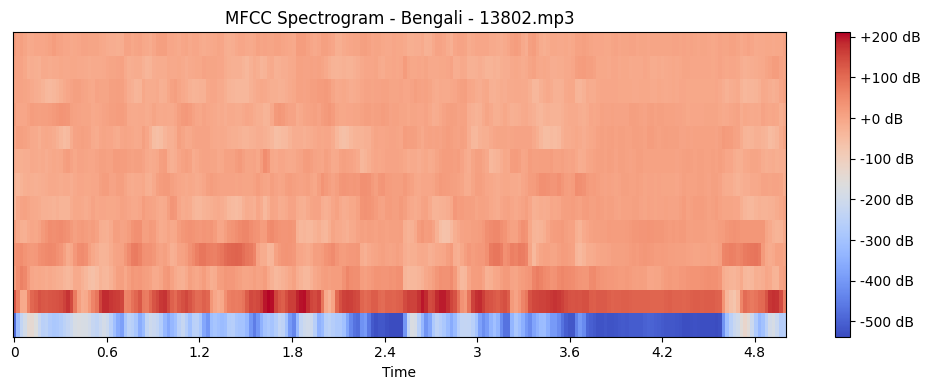

Processing: 23694.mp3 (Urdu)


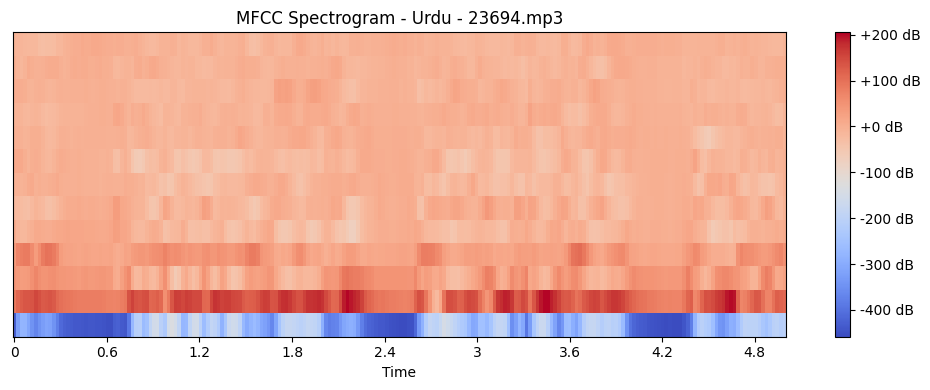

Processing: 13738.mp3 (Urdu)


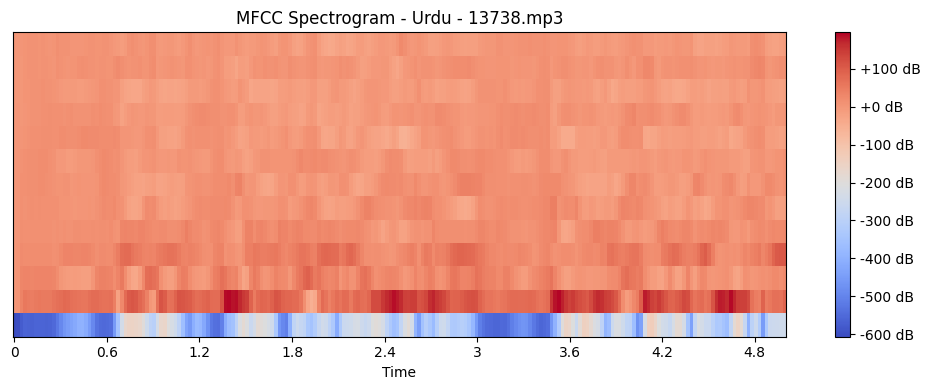

Processing: 13802.mp3 (Urdu)


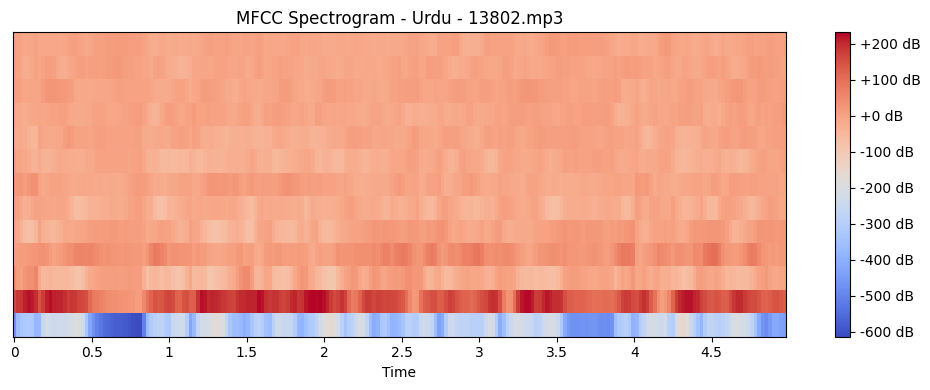

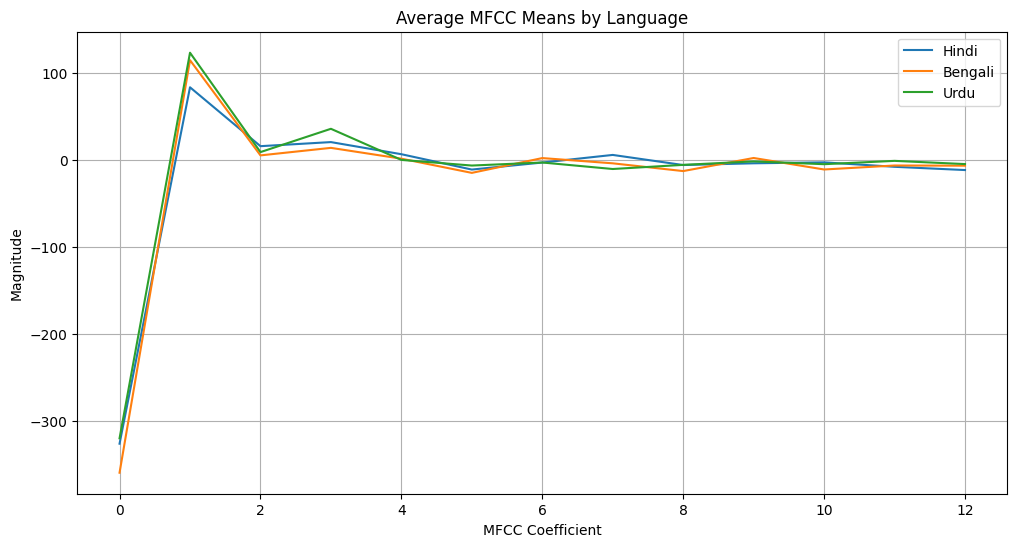

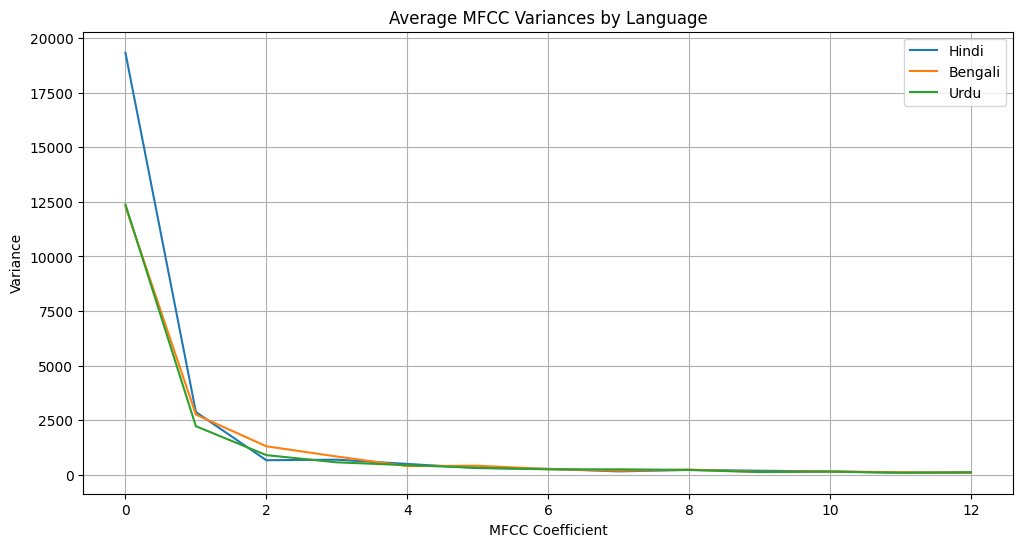

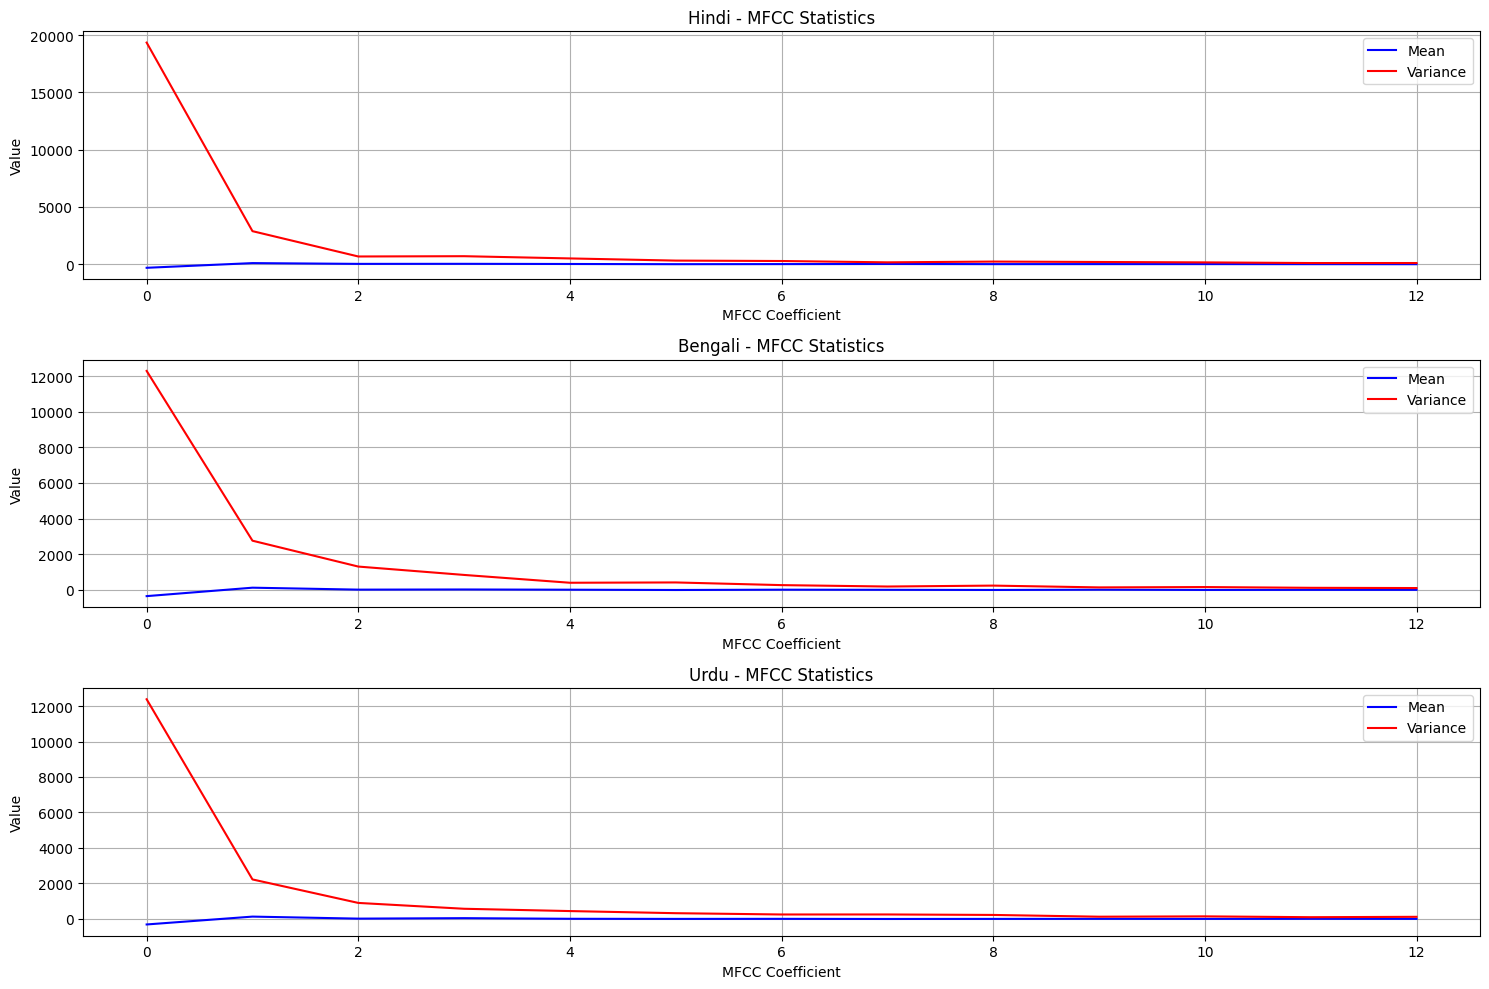

In [8]:
# Define selected languages for Task A
selected_languages = ['Hindi', 'Bengali', 'Urdu']

# Run Task A
language_stats = run_task_a(
    data_path=DATA_PATH,
    selected_languages=selected_languages,
    num_samples=3
)

# Task B: Language Classification

In [9]:
class FeatureExtractor:  
    def __init__(self, n_mfcc=13, sr=22050, hop_length=512, n_fft=2048):
        self.n_mfcc = n_mfcc
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
    
    def extract_features(self, file_path):
        try:
            # Load audio file
            y, sr = librosa.load(file_path, sr=self.sr)
            
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                hop_length=self.hop_length,
                n_fft=self.n_fft
            )
            
            # Compute statistics as features
            mean_mfcc = np.mean(mfcc, axis=1)
            var_mfcc = np.var(mfcc, axis=1)
            
            # Additional features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            mean_chroma = np.mean(chroma, axis=1)
            
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            mean_spectral_contrast = np.mean(spectral_contrast, axis=1)
            
            # Combine features
            features = np.concatenate([
                mean_mfcc, 
                var_mfcc, 
                mean_chroma, 
                mean_spectral_contrast
            ])
            
            return features
        except Exception as e:
            print(f"Error extracting features from {file_path}: {e}")
            return None


In [10]:
class LanguageClassifier: 
    def __init__(self, classifier_type='random_forest'):
        self.classifier_type = classifier_type
        self.classifier = self._create_classifier()
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
    
    def _create_classifier(self):
        if self.classifier_type == 'random_forest':
            return RandomForestClassifier(
                n_estimators=100,
                max_depth=20,
                random_state=42
            )
        elif self.classifier_type == 'svm':
            return SVC(
                kernel='rbf',
                C=10,
                gamma='scale',
                probability=True,
                random_state=42
            )
    
    def fit(self, X, y):
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit classifier
        self.classifier.fit(X_scaled, y_encoded)
    
    def predict(self, X):
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        # Predict labels
        y_pred_encoded = self.classifier.predict(X_scaled)
        
        # Decode labels
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)
        
        return y_pred
    
    def evaluate(self, X, y):
        # Predict labels
        y_pred = self.predict(X)
        
        # Compute metrics
        accuracy = accuracy_score(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True)
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }

In [11]:
def run_task_b(data_path, languages=None, max_files_per_language=100):
    print("====================================")
    print("Task B: Language Classification")
    print("====================================")
    
    # Initialize data loader and feature extractor
    data_loader = DataLoader(data_path)
    feature_extractor = FeatureExtractor()
    
    # Get file paths
    file_paths = data_loader.get_file_paths(
        selected_languages=languages,
        max_files_per_language=max_files_per_language
    )
    
    # Extract features
    print("Extracting features...")
    X = []
    y = []
    
    for file_path, language in tqdm(file_paths):
        features = feature_extractor.extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(language)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    print(f"Extracted features from {len(X)} files across {len(np.unique(y))} languages")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Initialize and train classifier
    classifier_types = ['random_forest', 'svm']
    results = {}
    
    for classifier_type in classifier_types:
        print(f"\nTraining {classifier_type} classifier...")
        classifier = LanguageClassifier(classifier_type=classifier_type)
        classifier.fit(X_train, y_train)
        
        # Evaluate classifier
        print(f"Evaluating {classifier_type} classifier...")
        metrics = classifier.evaluate(X_test, y_test)
        results[classifier_type] = metrics
        
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print("Classification Report:")
        for lang, lang_metrics in metrics['classification_report'].items():
            if isinstance(lang_metrics, dict):
                print(f"  {lang}: f1-score={lang_metrics['f1-score']:.4f}")
    
    # Visualize confusion matrix for the best classifier
    best_classifier = max(results, key=lambda x: results[x]['accuracy'])
    print(f"\nBest classifier: {best_classifier} (Accuracy: {results[best_classifier]['accuracy']:.4f})")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results[best_classifier]['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=np.unique(y),
        yticklabels=np.unique(y)
    )
    plt.title(f'Confusion Matrix - {best_classifier}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Feature importance for Random Forest
    if 'random_forest' in results:
        rf_classifier = LanguageClassifier(classifier_type='random_forest')
        rf_classifier.fit(X_train, y_train)
        
        # Get feature importances
        importances = rf_classifier.classifier.feature_importances_
        feature_names = [f'MFCC Mean {i+1}' for i in range(13)] + \
                        [f'MFCC Var {i+1}' for i in range(13)] + \
                        [f'Chroma {i+1}' for i in range(12)] + \
                        [f'Spectral Contrast {i+1}' for i in range(7)]
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Visualize top 15 features
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title('Top 15 Features by Importance')
        plt.tight_layout()
        plt.show()
    
    return results

Task B: Language Classification
Extracting features...


100%|██████████| 500/500 [00:24<00:00, 20.07it/s]


Extracted features from 500 files across 10 languages
Training set: 400 samples
Test set: 100 samples

Training random_forest classifier...
Evaluating random_forest classifier...
Accuracy: 0.7000
Classification Report:
  Bengali: f1-score=0.6316
  Gujarati: f1-score=0.5000
  Hindi: f1-score=0.8421
  Kannada: f1-score=0.8889
  Malayalam: f1-score=0.8182
  Marathi: f1-score=0.7619
  Punjabi: f1-score=0.3158
  Tamil: f1-score=0.9524
  Telugu: f1-score=0.7778
  Urdu: f1-score=0.5217
  macro avg: f1-score=0.7010
  weighted avg: f1-score=0.7010

Training svm classifier...
Evaluating svm classifier...
Accuracy: 0.7700
Classification Report:
  Bengali: f1-score=0.8421
  Gujarati: f1-score=0.2727
  Hindi: f1-score=0.9474
  Kannada: f1-score=0.8889
  Malayalam: f1-score=0.9524
  Marathi: f1-score=0.8571
  Punjabi: f1-score=0.3810
  Tamil: f1-score=0.9524
  Telugu: f1-score=0.8421
  Urdu: f1-score=0.8421
  macro avg: f1-score=0.7778
  weighted avg: f1-score=0.7778

Best classifier: svm (Accuracy:

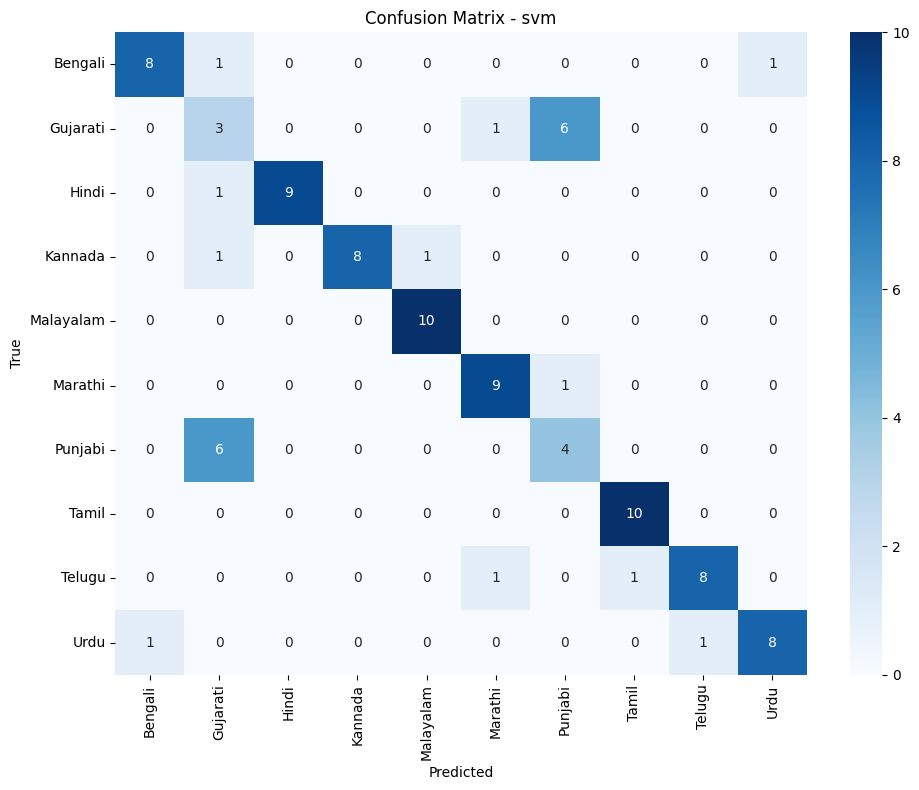

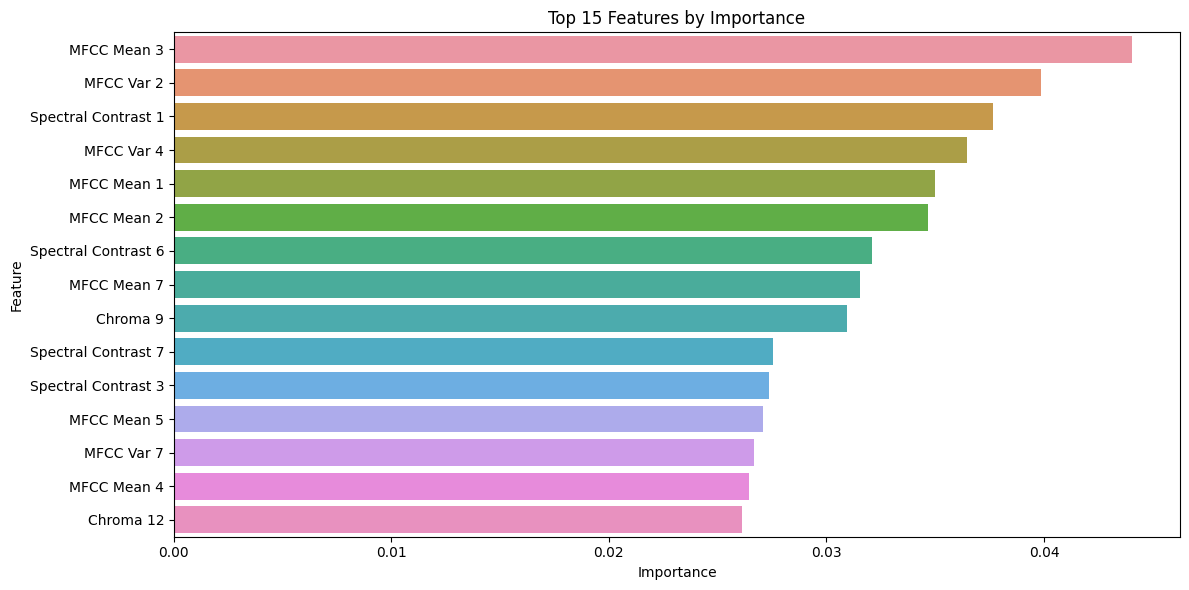

In [12]:
# Run Task B with all languages
results = run_task_b(
    data_path=DATA_PATH,
    max_files_per_language=50  # Limit to 50 files per language for faster execution
)